# Info
### : 각 언론사마다 기사를 쓸 때 어떤 단어를 중요하게 사용하는지 알아보기 위해 아래와 같은 방법을 사용하였다.
1. d2v를 사용해서 기사 title에 사용된 word들의 중요도에 대한 정보를 포함한 결과를 얻기 힘들다고 생각하였다.
2. title에 사용된 word들을 언론사마다 doc으로 하여 tf-idf 값을 구하였다.
3. 구해진 tf-idf 값을 weight로 하여 전체 word들에 w2v하여 얻은 결과에 곱해준다. 이때 tf-idf 값을 normalization하여 각 언론사에서 사용된 word들의 tf-idf 값의 합이 1이 되도록 하였다. 
###### => norm_tf-idf(i) = tf-idf(i)/sum_of_total_tf-idf (i = word)
4. UMAP(cosin)을 이용해 시각화하여 언론사들의 분포를 확인하고 clustering 해본다.

In [1]:
import pandas as pd
import glob

file_name = glob.glob('../article/headline_noun_keyword*')

keyword_df = []
for file in file_name:
    df = pd.read_pickle(file)
    keyword_df.append(df)

keyword_all = pd.concat(keyword_df, ignore_index = True)
keyword = keyword_all[keyword_all['week'] <= 807]

In [2]:
keyword = keyword.sort_values(by = 'date', ascending = True, ignore_index = True)

In [3]:
gu_name = ['강남구','강동구','강서구','강북구','관악구','광진구','구로구','금천구',
          '노원구','동대문구','도봉구','동작구','마포구','서대문구','성동구','성북구',
          '서초구','송파구','영등포구','용산구','양천구','은평구','종로구','중구','중랑구']

many = len(gu_name)

In [4]:
read_path = "../seoul_apt_trade_data/"

trade_df = pd.DataFrame()
for gu in gu_name:
    gu_df = pd.read_pickle(f"{read_path}{gu}_trade.pkl")
    gu_df['구'] = gu
    trade_df = pd.concat([trade_df,gu_df])

In [5]:
trade_df

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,면적당가격,거래주,count,구
0,11680,개포동,2006-01-02,시영,656,51.18,3,1984,65000,1270.027354,0,1,강남구
1,11680,개포동,2006-01-02,개포현대200동,655-1,82.20,8,1986,58000,705.596107,0,1,강남구
2,11680,개포동,2006-01-02,개포주공 4단지,189,35.64,4,1982,39200,1099.887767,0,1,강남구
3,11680,개포동,2006-01-03,개포주공 3단지,138,41.99,1,1982,62000,1476.542034,0,1,강남구
4,11680,개포동,2006-01-03,개포주공 7단지,185,53.46,13,1983,49200,920.314254,0,1,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39643,11260,중화동,2021-06-08,한신1차,450,59.76,20,1998,72500,1213.186078,805,1,중랑구
39644,11260,중화동,2021-06-10,청원다미소,286-22,84.82,12,2004,76300,899.551992,805,1,중랑구
39645,11260,중화동,2021-06-11,한신1차,450,59.76,16,1998,71000,1188.085676,805,1,중랑구
39646,11260,중화동,2021-06-24,한신1차,450,59.76,2,1998,66000,1104.417671,807,1,중랑구


In [6]:
co_list = list(set(keyword['co']))

1. 먼저 최근 쓰여진 기사들(문재인 정부)을 이용해 부분적으로 분석해 본다. 이유는 언론사 마다 성향이 있기 때문에 정권을 나누어 확인하는게 적절하다고 생각하였기 때문이다.

In [7]:
ji = (592, 808)

In [8]:
ji_trade_df = trade_df[(trade_df['거래주'] >= ji[0]) & (trade_df['거래주'] < ji[1])]

In [9]:
ji_trade_df

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,면적당가격,거래주,count,구
56015,11680,개포동,2017-05-07,현대1차101동~106동,653,95.40,8,1984,110000,1153.039832,592,1,강남구
56016,11680,개포동,2017-05-08,삼익대청아파트,12,60.00,8,1992,84000,1400.000000,592,1,강남구
56017,11680,개포동,2017-05-08,개포주공 1단지,141,50.64,2,1982,120000,2369.668246,592,1,강남구
56018,11680,개포동,2017-05-08,개포주공 4단지,189,50.39,3,1982,105000,2083.746775,592,1,강남구
56019,11680,개포동,2017-05-08,개포우성3차,652,104.43,12,1984,111000,1062.912956,592,1,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39642,11260,중화동,2021-06-05,한신1차,450,50.37,24,1998,62500,1240.817947,804,1,중랑구
39643,11260,중화동,2021-06-08,한신1차,450,59.76,20,1998,72500,1213.186078,805,1,중랑구
39644,11260,중화동,2021-06-10,청원다미소,286-22,84.82,12,2004,76300,899.551992,805,1,중랑구
39645,11260,중화동,2021-06-11,한신1차,450,59.76,16,1998,71000,1188.085676,805,1,중랑구


In [10]:
ji_article = keyword[(keyword['week'] >= ji[0]) & (keyword['week'] < ji[1])]

In [11]:
gu_weekly_price = ji_trade_df.groupby(['구','거래주'])['면적당가격'].median()
gu_weekly_price

구    거래주
강남구  592    1381.833296
     593    1414.141414
     594    1414.304644
     595    1393.728223
     596    1365.509123
               ...     
중랑구  803    1043.429140
     804     969.513831
     805     935.021060
     806     950.309520
     807     952.564597
Name: 면적당가격, Length: 5400, dtype: float64

In [40]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=12)

In [13]:
ji_article

,date,co,headline,week,pos
683643,2017.05.07. 오전 10:27,매일경제,금융당국 대출심사 DSR 복수 기준 도입 검토,592,"[금융, 당국, 대출, 심사, 복수, 기준, 도입, 검토]"
683644,2017.05.07. 오전 10:29,헤럴드경제,서울 프라임급 오피스 수익률 1.70%…공실은 소폭 증가,592,"[서울, 프라임, 급, 오피스, 수익, 공실, 소폭, 증가]"
683645,2017.05.07. 오전 10:38,이데일리,1분기 서울시내 대형빌딩 빈 사무실 늘었다,592,"[분기, 서울, 시내, 대형, 빌딩, 사무실]"
683646,2017.05.07. 오전 10:42,이데일리,서울 전세 재계약 비용 강남보다 강북이 더 올랐다,592,"[서울, 전세, 재계약, 비용, 강남, 강북]"
683647,2017.05.07. 오전 11:00,머니투데이,대형 철도사고 막아라…철도안전 예산 2.5조 투입,592,"[대형, 철도, 사고, 철도, 안전, 예산, 조, 투, 입]"
...,...,...,...,...,...
1065646,2021.06.26. 오후 6:33,매일신문,DL건설 대구 동인동 재개발사업 수주…7개동 376가구 건립,807,"[건설, 대구, 동인동, 개발, 사업, 수주, 개동, 가구, 건립]"
1065647,2021.06.26. 오후 6:42,아시아경제,‘현금부자’ 몰린 원베일리... 다음 주목할 분양 단지는,807,"[현금, 부자, 원, 베일리, 다음, 주목, 분양, 단지]"
1065648,2021.06.26. 오후 7:01,매일경제,6억 전세가 12억…줄서서 전셋집을 구경하는 사진 남의 일 아니다핫이슈,807,"[억, 전세, 억, 셋집, 구경, 사진, 남, 일, 핫]"
1065649,2021.06.26. 오후 7:04,아시아경제,“우선공급권 막차 타자”… 투기수요 몰리는 재개발 후보지,807,"[공급, 막차, 타자, 투기, 수요, 개발, 후보지]"


In [14]:
ji_co_list = ji_article.groupby(['co']).count()['week']
ji_co_list = ji_co_list[ji_co_list > 5000]
ji_co_list, len(ji_co_list)

(co
 뉴스1       10703
 뉴시스       21720
 데일리안      11546
 동아일보      10166
 디지털타임스    14546
 매일경제      35158
 머니S       18930
 머니투데이     18567
 서울경제      21649
 아시아경제     24681
 아이뉴스24     5909
 연합뉴스      23702
 이데일리      29951
 조선비즈       8405
 파이낸셜뉴스    28707
 한국경제      24494
 한국경제TV    17724
 헤럴드경제     23908
 Name: week, dtype: int64,
 18)

In [15]:
ji_article.index = [i for i in range(len(ji_article))]
ji_article

,date,co,headline,week,pos
0,2017.05.07. 오전 10:27,매일경제,금융당국 대출심사 DSR 복수 기준 도입 검토,592,"[금융, 당국, 대출, 심사, 복수, 기준, 도입, 검토]"
1,2017.05.07. 오전 10:29,헤럴드경제,서울 프라임급 오피스 수익률 1.70%…공실은 소폭 증가,592,"[서울, 프라임, 급, 오피스, 수익, 공실, 소폭, 증가]"
2,2017.05.07. 오전 10:38,이데일리,1분기 서울시내 대형빌딩 빈 사무실 늘었다,592,"[분기, 서울, 시내, 대형, 빌딩, 사무실]"
3,2017.05.07. 오전 10:42,이데일리,서울 전세 재계약 비용 강남보다 강북이 더 올랐다,592,"[서울, 전세, 재계약, 비용, 강남, 강북]"
4,2017.05.07. 오전 11:00,머니투데이,대형 철도사고 막아라…철도안전 예산 2.5조 투입,592,"[대형, 철도, 사고, 철도, 안전, 예산, 조, 투, 입]"
...,...,...,...,...,...
382003,2021.06.26. 오후 6:33,매일신문,DL건설 대구 동인동 재개발사업 수주…7개동 376가구 건립,807,"[건설, 대구, 동인동, 개발, 사업, 수주, 개동, 가구, 건립]"
382004,2021.06.26. 오후 6:42,아시아경제,‘현금부자’ 몰린 원베일리... 다음 주목할 분양 단지는,807,"[현금, 부자, 원, 베일리, 다음, 주목, 분양, 단지]"
382005,2021.06.26. 오후 7:01,매일경제,6억 전세가 12억…줄서서 전셋집을 구경하는 사진 남의 일 아니다핫이슈,807,"[억, 전세, 억, 셋집, 구경, 사진, 남, 일, 핫]"
382006,2021.06.26. 오후 7:04,아시아경제,“우선공급권 막차 타자”… 투기수요 몰리는 재개발 후보지,807,"[공급, 막차, 타자, 투기, 수요, 개발, 후보지]"


In [16]:
ji_co_list

co
뉴스1       10703
뉴시스       21720
데일리안      11546
동아일보      10166
디지털타임스    14546
매일경제      35158
머니S       18930
머니투데이     18567
서울경제      21649
아시아경제     24681
아이뉴스24     5909
연합뉴스      23702
이데일리      29951
조선비즈       8405
파이낸셜뉴스    28707
한국경제      24494
한국경제TV    17724
헤럴드경제     23908
Name: week, dtype: int64

In [17]:
word_list = ji_article[ji_article['co'] == '매일경제']['pos'].sum()

In [44]:
from math import log
import re

docs = []
for co in ji_co_list.index:
    word_str = ''
    word_list = ji_article[ji_article['co'] == co]['pos'].sum()
    for w in word_list:
        w_hangeul = re.compile('[|ㄱ-ㅎ|가-힣]+').findall(w)
        for h in w_hangeul:
            if len(h) >= 2:
                word_str += h + ' '
    docs.append(word_str)
    print(f'>>> save {co} article word to docs')

vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()

N = len(docs) # 총 문서의 수

>>> save 뉴스1 article word to docs
>>> save 뉴시스 article word to docs
>>> save 데일리안 article word to docs
>>> save 동아일보 article word to docs
>>> save 디지털타임스 article word to docs
>>> save 매일경제 article word to docs
>>> save 머니S article word to docs
>>> save 머니투데이 article word to docs
>>> save 서울경제 article word to docs
>>> save 아시아경제 article word to docs
>>> save 아이뉴스24 article word to docs
>>> save 연합뉴스 article word to docs
>>> save 이데일리 article word to docs
>>> save 조선비즈 article word to docs
>>> save 파이낸셜뉴스 article word to docs
>>> save 한국경제 article word to docs
>>> save 한국경제TV article word to docs
>>> save 헤럴드경제 article word to docs


In [42]:
def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1))

def tfidf(t, d):
    return tf(t,d)* idf(t)

result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = docs[i]
    for j,t in enumerate(vocab):
        result[-1].append(tf(t, d))
    if(i%5 == 0):print(f">>> {i} end")
print(f">>> article word to docs end")

tf_ = pd.DataFrame(result, columns = vocab)

result = []
for j, t in enumerate(vocab):
    result.append(idf(t))

idf_ = pd.DataFrame(result, index = vocab, columns = ["IDF"])
idf_ = idf_ + 1

tfidf_ = pd.DataFrame()
i = 0
for i, c in enumerate(tf_.columns):
    tfidf_[c] = tf_[c] * idf_.loc[c,'IDF']
    if(i % 1000 == 0): print(f'>>> {i} end')
print(f">>> tfidf_ end")

>>> save 뉴스1 article word to docs
>>> save 뉴시스 article word to docs
>>> save 데일리안 article word to docs
>>> save 동아일보 article word to docs
>>> save 디지털타임스 article word to docs
>>> save 매일경제 article word to docs
>>> save 머니S article word to docs
>>> save 머니투데이 article word to docs
>>> save 서울경제 article word to docs
>>> save 아시아경제 article word to docs
>>> save 아이뉴스24 article word to docs
>>> save 연합뉴스 article word to docs
>>> save 이데일리 article word to docs
>>> save 조선비즈 article word to docs
>>> save 파이낸셜뉴스 article word to docs
>>> save 한국경제 article word to docs
>>> save 한국경제TV article word to docs
>>> save 헤럴드경제 article word to docs
>>> 0 end
>>> 5 end
>>> 10 end
>>> 15 end
>>> article word to docs end
>>> 0 end


/tmp/ipykernel_365152/3746304163.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_[c] = tf_[c] * idf_.loc[c,'IDF']


>>> 1000 end
>>> 2000 end
>>> 3000 end
>>> 4000 end
>>> 5000 end
>>> 6000 end
>>> 7000 end
>>> 8000 end
>>> 9000 end
>>> 10000 end
>>> 11000 end
>>> 12000 end
>>> 13000 end
>>> 14000 end
>>> 15000 end
>>> 16000 end
>>> 17000 end
>>> 18000 end
>>> 19000 end
>>> 20000 end
>>> 21000 end
>>> 22000 end
>>> 23000 end
>>> 24000 end
>>> 25000 end
>>> 26000 end
>>> 27000 end
>>> 28000 end
>>> 29000 end
>>> 30000 end
>>> tfidf_ end


In [43]:
# save ft-idf files
tfidf_.to_pickle("../article/tfidf_selected_co.pkl")
tf_.to_pickle("../article/tf_selected_co.pkl")
idf_.to_pickle("../article/idf_selected_co.pkl")

In [45]:
tfidf_ = pd.read_pickle("../article/tfidf_selected_co.pkl")
tf_ = pd.read_pickle("../article/tf_selected_co.pkl")
idf_ = pd.read_pickle("../article/idf_selected_co.pkl")

In [46]:
result = []
docs_n = len(docs)
for i in range(docs_n):
    result.append(docs[i].split())

In [47]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=result, vector_size=100, window=8, min_count=50, workers=10, epochs = 10)

In [48]:
labels = []
tokens = []
words_wv = list(model.wv.index_to_key)
for word in words_wv:
    tokens.append(model.wv[word])
    labels.append(word)

In [49]:
tfidf_vec = pd.DataFrame()

for i, w in enumerate(labels):
    tfidf_vec[w] = [idf*tokens[i] for idf in tfidf_[w]]

/tmp/ipykernel_434004/2459724769.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_vec[w] = [idf*tokens[i] for idf in tfidf_[w]]


In [50]:
import numpy as np

co_vec = []
tivl = len(tfidf_vec)
tivnp = np.array(tfidf_vec)
for i in range(tivl):
    co_vec.append(sum(tivnp[i]))

In [51]:
nomalized_tfidf = {}

for i in tfidf_.index:
    sum_of_row = sum(tfidf_.iloc[i,:])
    nomalized_tfidf[i] = tfidf_.iloc[i,:]/sum_of_row

In [52]:
nomalized_tfidf = pd.DataFrame(nomalized_tfidf)
nomalized_tfidf = nomalized_tfidf.transpose()
nomalized_tfidf

,가가호호,가거도항,가게,가격,가격대,가격표,가결,가경,가경동,가경자,...,힐마,힐사이드,힐스,힐즈,힐튼,힐티,힘겨루기,힘스,힘줄,힙스터
0,0.000111,0.000000,0.000000,0.003855,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000013,0.001139,0.000000,0.000013,0.000073,0.000048,0.000000,0.000000,...,0.000000,0.000000,0.000043,0.000076,0.000009,0.000008,0.000028,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000012,0.001187,0.000012,0.000000,0.000010,0.000078,0.000000,0.000013,...,0.000000,0.000000,0.000192,0.000078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000027,0.001190,0.000014,0.000000,0.000000,0.000072,0.000000,0.000046,...,0.000000,0.000000,0.000532,0.000113,0.000000,0.000000,0.000015,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.001276,0.000000,0.000000,0.000000,0.000029,0.000000,0.000000,...,0.000000,0.000000,0.000258,0.000065,0.000000,0.000023,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000015,0.000948,0.000004,0.000000,0.000036,0.000044,0.000007,0.000012,...,0.000000,0.000018,0.000453,0.000205,0.000005,0.000004,0.000008,0.000008,0.000000,0.000000
6,0.000000,0.000018,0.000007,0.001522,0.000008,0.000000,0.000033,0.000033,0.000014,0.000000,...,0.000000,0.000000,0.000138,0.000050,0.000000,0.000009,0.000000,0.000000,0.000000,0.000015
7,0.000000,0.000000,0.000016,0.001049,0.000000,0.000000,0.000092,0.000024,0.000000,0.000009,...,0.000000,0.000000,0.000048,0.000060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.001043,0.000007,0.000000,0.000041,0.000040,0.000012,0.000007,...,0.000000,0.000000,0.000232,0.000094,0.000009,0.000016,0.000007,0.000000,0.000016,0.000014
9,0.000000,0.000000,0.000000,0.001291,0.000006,0.000000,0.000044,0.000041,0.000000,0.000025,...,0.000000,0.000000,0.000447,0.000116,0.000000,0.000007,0.000006,0.000000,0.000000,0.000000


In [53]:
nomalized_tfidf_vec = pd.DataFrame()

for i in range(len(labels)):
    w = labels[i]
    nomalized_tfidf_vec[w] = [tfidf*tokens[i] for tfidf in nomalized_tfidf[w]]

/tmp/ipykernel_434004/3254773586.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nomalized_tfidf_vec[w] = [tfidf*tokens[i] for tfidf in nomalized_tfidf[w]]


In [54]:
nomalized_tfidf_vec

,분양,주택,아파트,서울,부동산,건설,도시,개발,가구,공급,...,렌터카,해답,미술,초유,창문,봉덕,장지수,생사,감자,조선업
0,"[-0.003440287, -0.0028458855, -0.0052527986, 0...","[-0.023837633, 0.0060005463, 0.0055581126, 0.0...","[-0.0061520147, -0.0034322748, -0.01002307, 0....","[-0.0045177396, -0.012911715, -0.007955275, 0....","[-0.010758802, -0.002694831, 0.0068907733, -0....","[-0.0069303457, 0.0035576606, -0.0006035964, -...","[0.0062446073, -0.0059273094, -0.0035018965, 0...","[0.0011036434, 0.0024782121, 0.002723943, -0.0...","[-0.0019011265, 0.00024560094, -0.0014156405, ...","[-0.0020300609, -0.0053802244, -0.0029520984, ...",...,"[1.6263522e-07, 6.944093e-08, 3.44386e-07, -3....","[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[1.2704185e-08, 3.2332375e-07, 5.570804e-07, -...","[1.3841874e-07, 3.7828022e-07, 3.2518253e-07, ...","[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0....","[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0...","[-1.2069153e-05, 2.823917e-05, 1.18642865e-05,...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0....","[0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -..."
1,"[-0.0072359466, -0.0059857434, -0.011048198, 0...","[-0.01541811, 0.0038811355, 0.0035949708, 0.00...","[-0.003294912, -0.0018382666, -0.0053681815, 0...","[-0.0032573328, -0.009309468, -0.005735828, 0....","[-0.0038961903, -0.0009759055, 0.0024954232, -...","[-0.013891885, 0.0071313344, -0.0012099096, -0...","[0.004966971, -0.004714592, -0.0027854145, 0.0...","[0.0013168269, 0.0029569117, 0.0032501088, -0....","[-0.0032283133, 0.0004170563, -0.0024039068, 0...","[-0.0013056607, -0.0034603633, -0.0018986814, ...",...,"[5.333976e-07, 2.2774667e-07, 1.129489e-06, -1...","[-5.5136887e-08, 1.356275e-07, 8.042177e-08, 4...","[6.249922e-08, 1.5906161e-06, 2.7405997e-06, -...","[5.674681e-08, 1.5508157e-07, 1.3331338e-07, -...","[-1.6092348e-07, 4.245865e-07, 1.59988e-07, 6....","[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0...","[-4.4371742e-08, 4.840241e-07, -4.615306e-07, ...","[-2.4739638e-06, 5.7885327e-06, 2.4319697e-06,...","[4.6237568e-07, 1.1968496e-06, -7.217822e-07, ...","[4.5868035e-08, -1.561667e-07, -1.282211e-07, ..."
2,"[-0.012181575, -0.010076882, -0.018599426, 0.0...","[-0.017091813, 0.0043024495, 0.0039852206, 0.0...","[-0.0033518148, -0.0018700133, -0.0054608895, ...","[-0.0025957169, -0.007418568, -0.0045707906, 0...","[-0.0043464066, -0.0010886743, 0.0027837765, -...","[-0.016522653, 0.008481828, -0.0014390356, -0....","[0.0052866717, -0.0050180485, -0.0029646985, 0...","[0.0016371857, 0.0036762718, 0.004040798, -0.0...","[-0.0044746697, 0.0005780694, -0.0033319842, 0...","[-0.0016189392, -0.0042906385, -0.0023542487, ...",...,"[2.4408087e-07, 1.0421606e-07, 5.1685015e-07, ...","[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[6.673198e-08, 1.6983406e-06, 2.9262071e-06, -...","[1.0386856e-07, 2.8385912e-07, 2.4401493e-07, ...","[-2.9455205e-07, 7.771571e-07, 2.9283976e-07, ...","[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0...","[-8.1217415e-08, 8.859509e-07, -8.447791e-07, ...","[-1.5094361e-06, 3.5317494e-06, 1.4838143e-06,...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0....","[0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -..."
3,"[-0.02341926, -0.019372957, -0.035757672, 0.04...","[-0.015926076, 0.0040090038, 0.003713411, 0.00...","[-0.006674935, -0.0037240176, -0.010875029, 0....","[-0.003276541, -0.009364366, -0.005769652, 0.0...","[-0.004689301, -0.0011745613, 0.0030033926, -0...","[-0.009304802, 0.0047765765, -0.00081039895, -...","[0.005727579, -0.005436552, -0.0032119537, 0.0...","[0.0011325628, 0.0025431497, 0.0027953195, -0....","[-0.0030204968, 0.0003902091, -0.00224916, 0.0...","[-0.0021180804, -0.005613501, -0.0030800959, 0...",...,"[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -...","[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[3.3579372e-08, 8.5460096e-07, 1.4724604e-06, ...","[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0...","[-5.187626e-07, 1.3687225e-06, 5.1574693e-07, ...","[-1.0

In [55]:
nomalized_co_vec = []
many_of_word = len(labels)

tivl = len(nomalized_tfidf_vec)
for i in range(tivl):
    nomalized_co_vec.append(sum(nomalized_tfidf_vec.iloc[i,:]))

In [56]:
import umap.umap_ as umap

reducer = umap.UMAP(metric = 'cosine')
tokens += nomalized_co_vec
labels += list(ji_co_list.index)
embedding = reducer.fit_transform(tokens)
embedding.shape

(4337, 2)

UMAP result 1: word embedding and company vector(using f-idf)

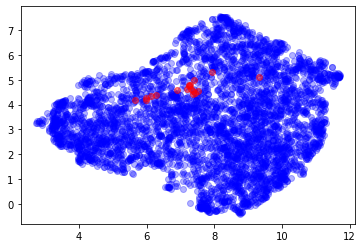

In [57]:
plt.scatter(embedding[:-18,0],embedding[:-18,1], color = 'b', alpha=0.3)
plt.scatter(embedding[-18:,0],embedding[-18:,1], color = 'r', alpha=0.5)

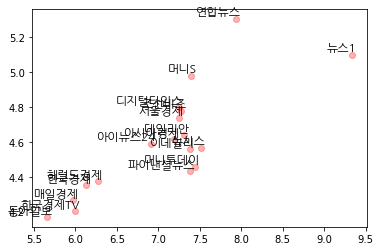

In [58]:
plt.scatter(embedding[-18:,0],embedding[-18:,1], color = 'r', alpha=0.3)
        
for i, vector in enumerate(embedding[-18:,0]):
    plt.annotate(labels[-18+i],
                 xy=(embedding[-18+i,0],embedding[-18+i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom', fontproperties=fontprop)

In [59]:
import numpy as np
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3).fit(embedding[-18:])
labels = kmeans_model.labels_

Text(0.5, 1.0, 'cluster result')

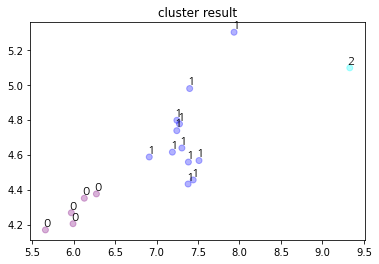

In [60]:
color = {0:'purple', 1:'b', 2:'cyan'}
C = [color[l] for l in labels]
plt.scatter(embedding[-18:,0],embedding[-18:,1], color = C, alpha=0.3)
for i, vector in enumerate(embedding[-18:,0]):
    plt.annotate(labels[-18+i],
                 xy=(embedding[-18+i,0],embedding[-18+i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom', fontproperties=fontprop)
plt.title("cluster result")